In [16]:
import numpy as np
from scipy import stats
import pandas as pd
import pickle
import pydot
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import multiprocessing
import time

import warnings
warnings.filterwarnings('ignore')

In [17]:
def causal_train_test_split(data, predictors, response, treatment, test_size = 0.25, estimation_size = 0.33):
    
    global PROP
    PROP = 1 - estimation_size
    
    train_set, test_set = train_test_split(data, test_size=test_size)
    training_sample, estimation_sample = train_test_split(train_set, test_size=estimation_size)
    training_sample.insert(loc = 0, column = 'TRAIN_ESTIMATION_IND', value = np.ones(len(training_sample)))
    estimation_sample.insert(loc = 0, column = 'TRAIN_ESTIMATION_IND', value = np.zeros(len(estimation_sample)))
    new_train_set = pd.concat([training_sample, estimation_sample])
    new_train_set = new_train_set[['TRAIN_ESTIMATION_IND'] + predictors + treatment + response]
    test_set = test_set[predictors + treatment + response]
    return new_train_set, test_set


In [18]:
def predictDataPoint(rf, data):
    test_set = pd.DataFrame([data], columns = data.keys())
    predict_list = []
    for tree in rf:
        pred_df = causalPredict(test_set, tree)
        pred_value = pred_df.iloc[0,-1]
        predict_list.append(pred_value)
    # calculate the predicted value    
    rf_pred_value = round(np.mean(predict_list),3)
    # calculate p-value
    positive_ratio = sum(x >0 for x in predict_list)/len(predict_list)
    if positive_ratio <= 0.5:
        p_value = 2*positive_ratio
    else:
        p_value = 2*(1-positive_ratio)
    print("Predicted causal effect: " + str(rf_pred_value) + "\n")
    print("P-value: " + str(p_value))

In [19]:
#causal effect prediction
def causalPredict_helper(node,row):
    if row[node['index'] - 1] < node['value']:
        if isinstance(node['left'], dict):
            return causalPredict_helper(node['left'], row)
        else:
            return node['left'][0]
    else:
        if isinstance(node['right'], dict):
            return causalPredict_helper(node['right'], row)
        else:
            return node['right'][0]    

# predict on one tree
def causalPredict(test, tree):
    #get the information of the trainning set and initialize an empty return dataframe
    column_names = list(test.columns) + ['pred_causal_effect']
    test_matrix = np.array(test)
    ret_matrix = np.empty([0, test_matrix.shape[1] + 1])
    
    #predict for each row
    for row in test_matrix:
        row = np.insert(row, len(row), causalPredict_helper(tree, row))
        ret_matrix = np.append(ret_matrix, [row], axis = 0) 
    
    #return a new dataframe with the predicted value at the end of each row
    ret_df = pd.DataFrame(ret_matrix, columns = column_names)

    return ret_df

# predict on multiple trees and take average
def predictTestSet(rf, test_set):
       
    n_trees = len(rf)
    n_test_set = len(test_set)
    pred_value_list = np.zeros([1,n_test_set])
    p_value_list = np.zeros([1,n_test_set])  
    
    for tree in rf:
        # get the prediction for each tree
        pred_df = causalPredict(test_set, tree)
        #print(pred_df.head())
        pred_values = np.array(pred_df['pred_causal_effect'])
        # print(pred_values)
        # aggregate the prediction
        pred_value_list = pred_value_list + pred_values
        #print(pred_value_list)
        
        # get the number of negative causal effect in the prediction
        pred_values[pred_values >= 0] = 0 # set positive causal effect to 0
        pred_values[pred_values < 0] = 1 # set negative causal effect to 1
        p_value_list = p_value_list + pred_values
        #break
        
    #calculate the prediction of bagged trees for each data point
    pred_value_rf = np.round_(pred_value_list / n_trees, decimals = 3)
    #calculate the p value of bagged trees for each data point
    p_value_rf = np.round_(p_value_list / n_trees, decimals = 3)
    #assert max(p_value_list) < n_trees
    
    #append the prediction and p_value to the dataset
    ret_data = test_set.copy(deep=True)
    ret_data['rf_pred_causal_effect'] = pred_value_rf[0]
    # calculate the p value against the hypothesis that the causal effect is not 0
    ret_data['rf_p_value'] = p_value_rf[0]
    ret_data['rf_p_value'] = ret_data['rf_p_value'].apply(lambda row: 2*row if row < 0.5 else 2*(1-row))
    
    return ret_data     

### load in the random forest models and data

In [21]:
#read in the pretrained random forest model
with open('random_forest_trained_model_rand_x2.pkl', 'rb') as fp:
    rf_rand = pickle.load(fp)

with open('random_forest_trained_model_25_x2.pkl', 'rb') as fp:
    rf_25 = pickle.load(fp)
    
with open('random_forest_trained_model_75_x2.pkl', 'rb') as fp:
    rf_75 = pickle.load(fp)

    
    
#read in the data to replicate the test set
rf_df_rand = pd.read_csv('fake_data_x2_rand.csv')
rf_df_25 = pd.read_csv('fake_data_x2_25.csv')
rf_df_75 = pd.read_csv('fake_data_x2_75.csv')

In [22]:
# random forest test
#get the column names of predictors
p_str = ['x1', 'x2','x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']
#get the column name of response
r_str = [['design1_y'],['design2_y'],['design3_y']]
#get the column name of treatment
t_str = ['treatment']

### create and predict on the test set

#### setup

In [49]:
### split to get test set
#test set for random x2
np.random.seed(42)
rf_test_set_rand_d1 = causal_train_test_split(rf_df_rand, predictors = p_str, response = ['design1_y'], treatment = t_str)[1]
np.random.seed(42)
rf_test_set_rand_d2 = causal_train_test_split(rf_df_rand, predictors = p_str, response = ['design2_y'], treatment = t_str)[1]
np.random.seed(42)
rf_test_set_rand_d3 = causal_train_test_split(rf_df_rand, predictors = p_str, response = ['design3_y'], treatment = t_str)[1]

#test set for x2 = 0.25
np.random.seed(42)
rf_test_set_25_d1 = causal_train_test_split(rf_df_25, predictors = p_str, response = ['design1_y'], treatment = t_str)[1]
np.random.seed(42)
rf_test_set_25_d2 = causal_train_test_split(rf_df_25, predictors = p_str, response = ['design2_y'], treatment = t_str)[1]
np.random.seed(42)
rf_test_set_25_d3 = causal_train_test_split(rf_df_25, predictors = p_str, response = ['design3_y'], treatment = t_str)[1]

#test set for x2 = 0.75
np.random.seed(42)
rf_test_set_75_d1 = causal_train_test_split(rf_df_75, predictors = p_str, response = ['design1_y'], treatment = t_str)[1]
np.random.seed(42)
rf_test_set_75_d2 = causal_train_test_split(rf_df_75, predictors = p_str, response = ['design2_y'], treatment = t_str)[1]
np.random.seed(42)
rf_test_set_75_d3 = causal_train_test_split(rf_df_75, predictors = p_str, response = ['design3_y'], treatment = t_str)[1]

### extract the trees
#x2 is rand
rf_rand_d1,rf_rand_d2,rf_rand_d3 = rf_rand
#x2 = 0.25
rf_25_d1,rf_25_d2,rf_25_d3 = rf_25
#x2 = 0.75
rf_75_d1,rf_75_d2,rf_75_d3 = rf_75

In [63]:
# make prediction on training data
#x2 is rand
pred_df_rand_d1 = predictTestSet(rf_rand_d1, rf_test_set_rand_d1)
pred_df_rand_d2 = predictTestSet(rf_rand_d2, rf_test_set_rand_d2)
pred_df_rand_d3 = predictTestSet(rf_rand_d3, rf_test_set_rand_d3)

#x2 = 0.25
pred_df_25_d1 = predictTestSet(rf_25_d1, rf_test_set_25_d1)
pred_df_25_d2 = predictTestSet(rf_25_d2, rf_test_set_25_d2)
pred_df_25_d3 = predictTestSet(rf_25_d3, rf_test_set_25_d3)
#x2 = 0.75
pred_df_75_d1 = predictTestSet(rf_75_d1, rf_test_set_75_d1)
pred_df_75_d2 = predictTestSet(rf_75_d2, rf_test_set_75_d2)
pred_df_75_d3 = predictTestSet(rf_75_d3, rf_test_set_75_d3)

In [64]:
# add true causal effect
pred_df_rand_d1["true_causal_eff"] = 1/2*rf_test_set_rand_d1['x1']
pred_df_25_d1["true_causal_eff"] = 1/2*rf_test_set_25_d1['x1']
pred_df_75_d1["true_causal_eff"] = 1/2*rf_test_set_75_d1['x1']

pred_df_rand_d2["true_causal_eff"] = rf_test_set_rand_d2['x1'].apply(lambda x: x if x > 0 else 0) + rf_test_set_rand_d2['x2'].apply(lambda x: x if x > 0.5 else 0)
pred_df_25_d2["true_causal_eff"] = rf_test_set_25_d2['x1'].apply(lambda x: x if x > 0 else 0) + rf_test_set_25_d2['x2'].apply(lambda x: x if x > 0.5 else 0)
pred_df_75_d2["true_causal_eff"] = rf_test_set_75_d2['x1'].apply(lambda x: x if x > 0 else 0) + rf_test_set_75_d2['x2'].apply(lambda x: x if x > 0.5 else 0)

pred_df_rand_d3["true_causal_eff"] = (1/2)*rf_test_set_rand_d3['x1'] + rf_test_set_rand_d3['x2']**2
pred_df_25_d3["true_causal_eff"] = (1/2)*rf_test_set_25_d3['x1'] + rf_test_set_25_d3['x2']**2
pred_df_75_d3["true_causal_eff"] = (1/2)*rf_test_set_75_d3['x1'] + rf_test_set_75_d3['x2']**2

In [52]:
rf_test_set_rand_d1.to_csv('test_set_for_r\\rf_test_set_rand_d1.csv')
rf_test_set_rand_d2.to_csv('test_set_for_r\\rf_test_set_rand_d2.csv')
rf_test_set_rand_d3.to_csv('test_set_for_r\\rf_test_set_rand_d3.csv')

rf_test_set_25_d1.to_csv('test_set_for_r\\rf_test_set_25_d1.csv')
rf_test_set_25_d2.to_csv('test_set_for_r\\rf_test_set_25_d2.csv')
rf_test_set_25_d3.to_csv('test_set_for_r\\rf_test_set_25_d3.csv')

rf_test_set_75_d1.to_csv('test_set_for_r\\rf_test_set_75_d1.csv')
rf_test_set_75_d2.to_csv('test_set_for_r\\rf_test_set_75_d2.csv')
rf_test_set_75_d3.to_csv('test_set_for_r\\rf_test_set_75_d3.csv')

In [103]:
pred_df_rand_d1.to_csv('predtf\\pred_df_rand_d1.csv')
pred_df_rand_d2.to_csv('predtf\\pred_df_rand_d2.csv')
pred_df_rand_d3.to_csv('predtf\\pred_df_rand_d3.csv')

pred_df_25_d1.to_csv('predtf\\pred_df_25_d1.csv')
pred_df_25_d2.to_csv('predtf\\pred_df_25_d2.csv')
pred_df_25_d3.to_csv('predtf\\pred_df_25_d3.csv')

pred_df_75_d1.to_csv('predtf\\pred_df_75_d1.csv')
pred_df_75_d2.to_csv('predtf\\pred_df_75_d2.csv')
pred_df_75_d3.to_csv('predtf\\pred_df_75_d3.csv')

In [65]:
pred_df_rand_d1.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,treatment,design1_y,true_causal_eff,rf_pred_causal_effect,rf_p_value
521,-1.452228,-0.108962,0.824852,-0.252727,-0.156696,0.308771,1.148122,-0.032390,1.453567,-1.485823,1.0,-1.200884,-0.726114,-0.523,0.14
737,-0.121588,-0.568209,0.787918,0.639315,-0.861697,-0.454570,1.186486,-1.206712,1.177696,2.125072,1.0,-0.675665,-0.060794,-0.279,0.38
740,-0.568494,0.708688,1.080158,0.550381,0.572502,2.913640,0.971390,-2.343501,2.297865,-2.204956,1.0,0.280647,-0.284247,-0.251,0.42
660,-2.543494,-0.066288,0.994549,-0.557003,-1.986345,-1.306131,2.747115,-0.636989,0.774824,1.862200,1.0,-1.983181,-1.271747,-0.603,0.12
411,0.650927,0.499013,0.995044,-0.273426,2.041053,2.770753,1.243463,-1.313403,0.613646,-0.765651,0.0,0.664021,0.325464,0.094,0.82


### visualization

In [106]:
def rf_plot(ret_df):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey = False)
    fig.set_figheight(6)
    fig.set_figwidth(15)
    sns.regplot(x = 'x1', y = 'rf_pred_causal_effect', data = ret_df,ax = ax1)
    #g.set(ylim=(-6,6))
    #g.set(ylim=(-1,1))
    #plt.plot(ret_df['x1'], ret_df['true_causal_eff'], 'red')
    sns.distplot((ret_df)['rf_p_value'], bins = 5, ax = ax2)

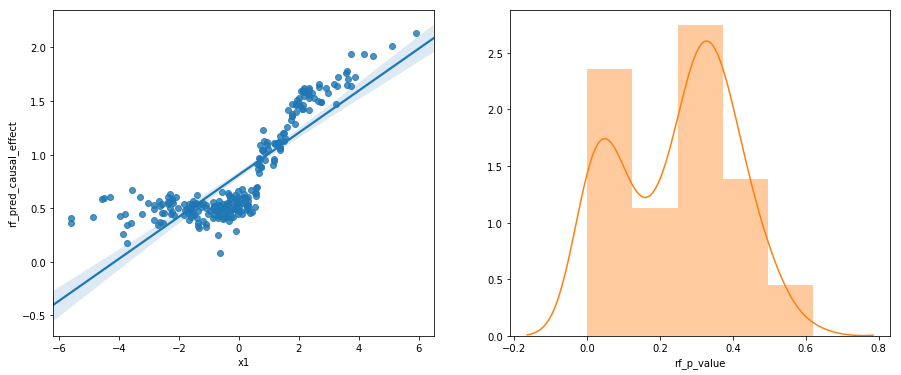

In [107]:
rf_plot(pred_df_25_d2)

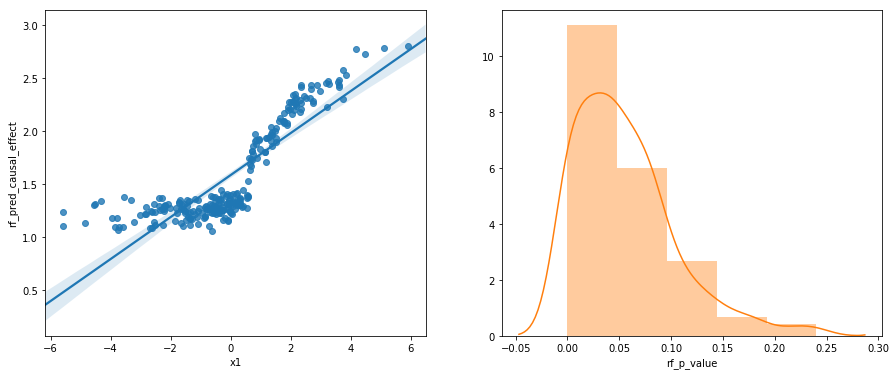

In [45]:
rf_plot(pred_df_75_d2)

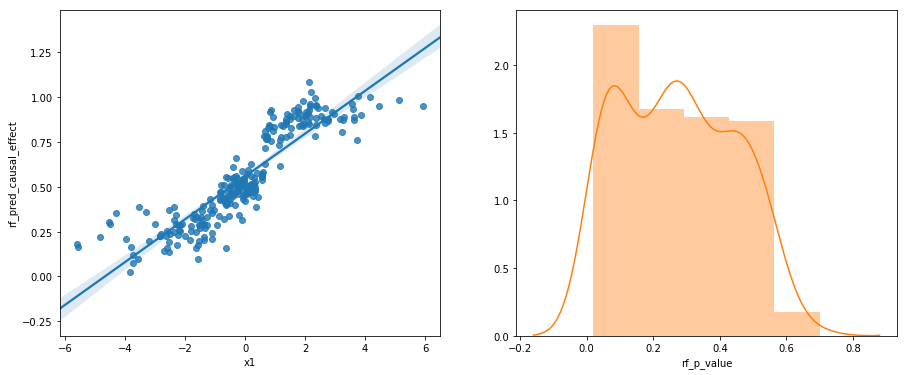

In [48]:
rf_plot(pred_df_75_d3)